In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Funzioni base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix

# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten, ScatterGroup, MatriceConfusione, indice_gini, tasso_errata_classificazione

### Caricamento dei dati

In [21]:
PATH_DATA = './PhonePi/data/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [22]:
DIR

['./PhonePi/data/camminata-alberto',
 './PhonePi/data/camminata-alberto.2',
 './PhonePi/data/camminata-anna',
 './PhonePi/data/camminata-daniele',
 './PhonePi/data/camminata-emanuele',
 './PhonePi/data/camminata-luisa',
 './PhonePi/data/camminata-luisa.2',
 './PhonePi/data/camminata-simone',
 './PhonePi/data/camminata_tasca-alberto',
 './PhonePi/data/camminata_tasca-alberto.2',
 './PhonePi/data/camminata_tasca-daniele',
 './PhonePi/data/camminata_tasca-emanuele',
 './PhonePi/data/camminata_tasca-luisa',
 './PhonePi/data/camminata_tasca-luisa.2',
 './PhonePi/data/camminata_tasca-simone',
 './PhonePi/data/corsa-alberto',
 './PhonePi/data/corsa-anna',
 './PhonePi/data/corsa-daniele',
 './PhonePi/data/corsa-luisa',
 './PhonePi/data/corsa-martina',
 './PhonePi/data/corsa_tasca-alberto',
 './PhonePi/data/corsa_tasca-anna',
 './PhonePi/data/corsa_tasca-daniele',
 './PhonePi/data/corsa_tasca-francesco',
 './PhonePi/data/corsa_tasca-luisa',
 './PhonePi/data/quotidiano-alberto',
 './PhonePi/data

In [23]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.12it/s]


#### Grafici per esempi

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]


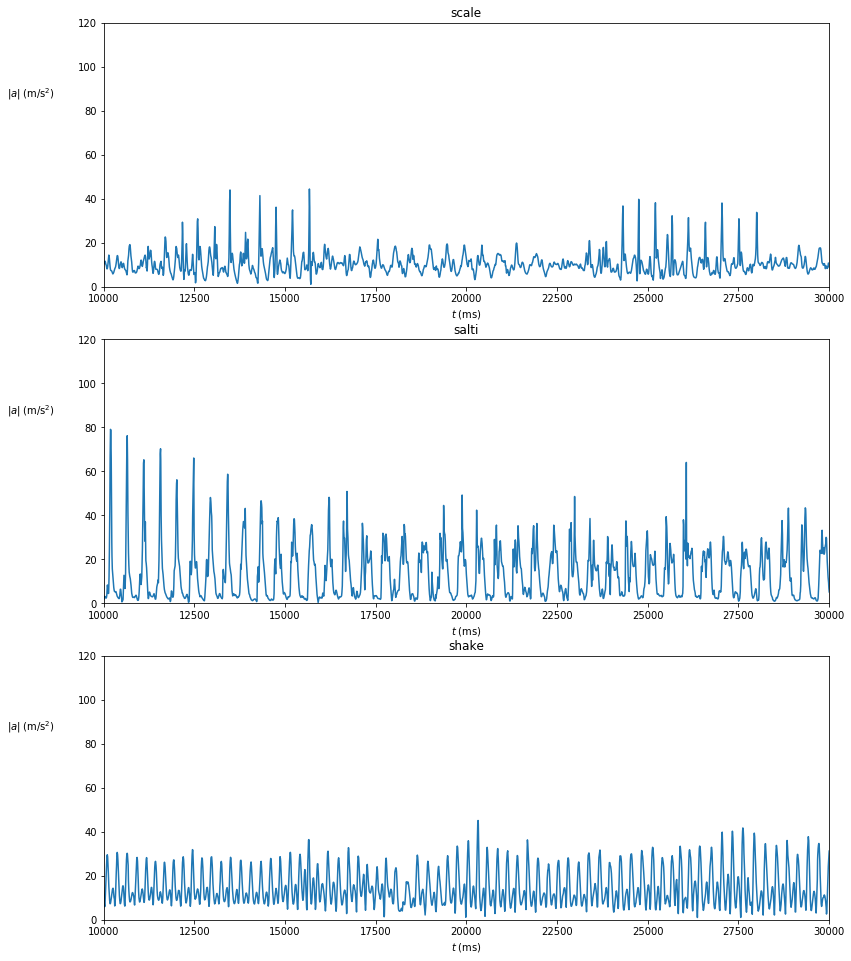

In [24]:
DIRM = ['./PhonePi/data/scale-martina',
        './PhonePi/data/salti-daniele',
        './PhonePi/data/shake-anna']

plt.figure(figsize=(13,5.5*len(DIRM)))
nrow = len(DIRM)
for i in tqdm.tqdm(range(len(DIRM))):
    data = pd.read_csv(DIRM[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120), xlim = (10000,30000))
    ax.set_ylabel(r"$\|a\|\;(\mathrm{ m/s}^2)$", rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.7)
    ax.set_xlabel(r"$t \;(\mathrm{ ms})$")
    ax.set_title((DIRM[i].split("/")[-1]).split("-")[0])
    plt.plot(data["t"],data["a"])
    plt.savefig("./figure/espl.png", dpi=150)    
plt.show()

### Calcolo delle variabili di riassunto

In [25]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

In [26]:
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
Mean = Xnum.mean(axis=1)
Var = Xnum.var(axis=1)
Med = Xnum.median(axis=1)
Min = Xnum.min(axis=1)

In [27]:
espl = pd.concat([maxA, MVDeriv, Mean, Var, Med, Min], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "Var", "Med", "Min"]

In [28]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [29]:
X.to_csv("X-2s.csv")
y.to_csv("y-2s.csv")
espl.to_csv("espl.csv")

In [30]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

### Analisi esplorativa con `PCA`, `ICA`, `t-SNE`

In [12]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

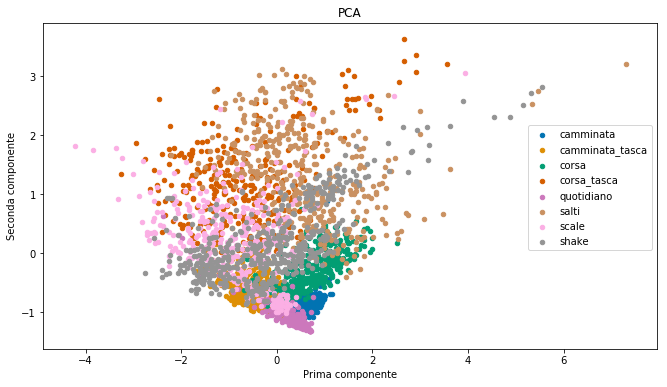

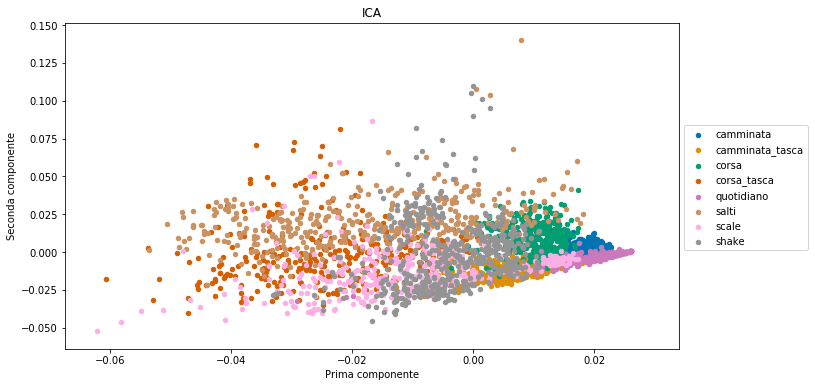

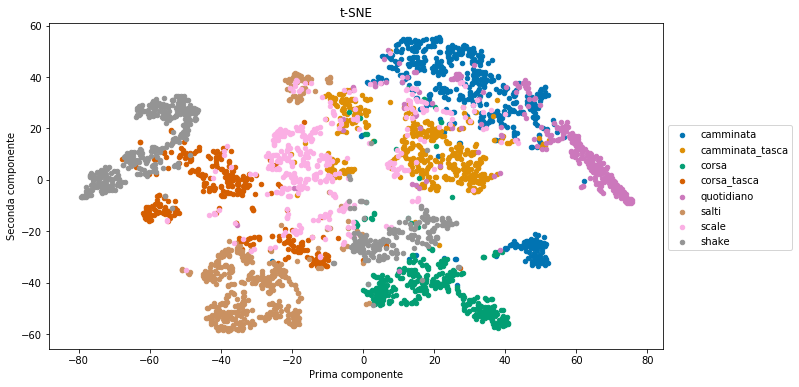

In [13]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig("./figure/"+title+".png", bbox_inches="tight", dpi=180)

### Analisi discriminante lineare e quadratica

Accuratezza LDA: 79.2%


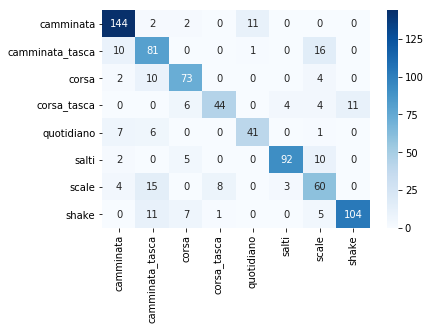

In [14]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine="./figure/matrice_confusione_lda")

Accuratezza QDA: 88.2%


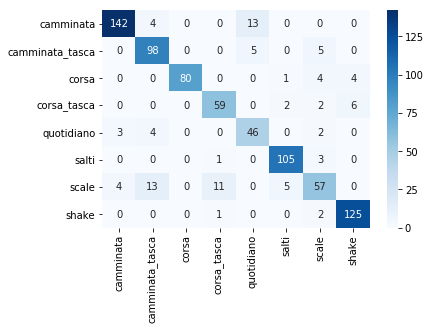

In [15]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine="./figure/matrice_confusione_qda")

In [16]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
print(weights)
weights[0] /= 30
weights = weights/weights.sum()
print(weights)

[0.15591398 0.15425972 0.13771712 0.13192721 0.12241522 0.10504549
 0.10339123 0.08933002]
[0.00611943 0.1816352  0.1621569  0.15533949 0.14413946 0.12368724
 0.12173941 0.10518285]


Accuratezza QDA: 83.9%


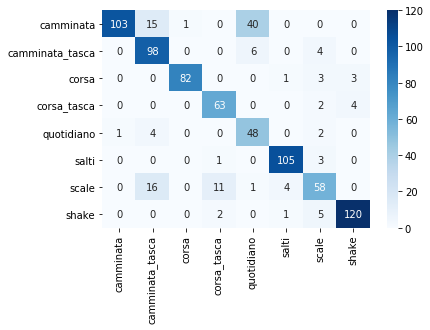

In [17]:
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda)